## GAN model

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set R, G is the generator, trying to create fake data that looks just like the genuine data, while D is the discriminator, getting data from either the real set or G and labeling the difference. Goodfellow’s metaphor (and a fine one it is) was that G was like a team of forgers trying to match real paintings with their output, while D was the team of detectives trying to tell the difference. (Except that in this case, the forgers G never get to see the original data — only the judgments of D. They’re like blind forgers.)

![GAN](https://raw.githubusercontent.com/manhlab/practike-gan-2021/main/gan-mnist.png)

Here's what we're going to do:

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
 - For discriminator
 -  For generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

![MNIST](https://i.imgur.com/CAYnuo1.jpeg)

### Define parameters & Load Dataset 

In [9]:
import torch 
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from IPython.display import Image
from torchvision.utils import save_image
from torch.utils.data import DataLoader

import os
%matplotlib inline 
plt.style.use("ggplot")
hidden_size = 256 
batch_size = 100 
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64 # input random input vector latent
image_size = 784 # 28*28 flatten
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.7354248 , -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.4551634 ,  0.587451  ,  0.71973854,  0.85202616,
         0.9843137 ], dtype=float32),
 <a list of 15 Patch objects>)

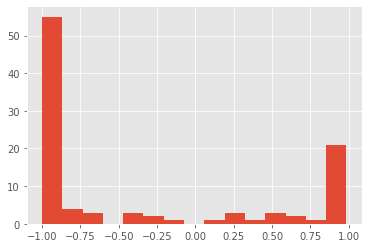

In [10]:
img, label = mnist[0]
print('Label: ', label)
plt.hist(img[:,5:15,5:15].flatten(), bins=15)

In [11]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    return (x+1)/2

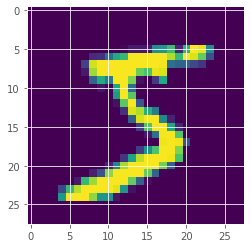

In [12]:
# show  image sample with matplotlib
plt.imshow(denorm(img[0]))

In [13]:
# define the dataloader
data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

In [14]:
# # define the dataloader
# bs = 100

# # MNIST Dataset
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
# test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# # Data Loader (Input Pipeline)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

GAN состоит из двух глубоких сетей, генератора и дискриминатора. генератор создает изображения, прежде чем научиться его обучать. Поскольку дискриминатор представляет собой модель бинарной классификации, мы можем использовать функцию потери бинарной кросс-энтропии для количественной оценки того, насколько хорошо он может различать реальные и сгенерированные изображения.

![](https://raw.githubusercontent.com/manhlab/practike-gan-2021/main/generator.png)

![](https://raw.githubusercontent.com/manhlab/practike-gan-2021/main/discriminator.png)

In [15]:
class Generator(nn.Module):
    def __init__(self, latent_size,image_size, hidden_size):
        super(Generator, self).__init__()
        ## set a linear layer with input size is latent_size and output size is hidden_size
        self.fc1 = nn.Linear(latent_size, hidden_size)
        #set a linear layer with input size is hidden_size and output size is hidden_size
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        #set a linear layer with input size is hidden_size and output size is image_size
        self.fc3 = nn.Linear(hidden_size, image_size)

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> tanh
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        ## set a linear layer with input size is latent_size and output size is hidden_size
        self.fc1 = nn.Linear(image_size, hidden_size)
        #set a linear layer with input size is hidden_size and output size is hidden_size
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        #set a linear layer with input size is hidden_size and output size is 1
        self.fc3 = nn.Linear(hidden_size, 1)

        
    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> sigmoid
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

## Create the Generator and Discriminator

In [16]:
# create new Generator model
G = Generator(latent_size, image_size, hidden_size)
# create new Discriminator model
D = Discriminator(image_size, hidden_size)


In [17]:
# show the output of model 
y = G(torch.randn(2, latent_size))
y

tensor([[ 0.1782,  0.1521, -0.1655,  ...,  0.0964, -0.1740, -0.0536],
        [ 0.0485,  0.1970, -0.1003,  ..., -0.0367, -0.0460,  0.0638]],
       grad_fn=<TanhBackward>)

In [18]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()

## Define the optimizer for generator and discrimator
G_optimizer = torch.optim.Adam(G.parameters(), lr = LR)
D_optimizer = torch.optim.Adam(D.parameters(), lr = LR)

### Discriminator Training

In [19]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

def train_discriminator(images):
  
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    
    outputs = D(images)
    # Loss for real images
    real_loss = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    # Sum losses
    d_loss = real_loss + fake_loss
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    D_optimizer.step()

    return d_loss, real_score, fake_score

### Generator Training

In [20]:
def train_generator():
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = G(z)
    fake_outputs = D(fake_images)
    labels = torch.ones(batch_size, 1).to(device)
    # calculate the generator loss
    g_loss = criterion(fake_outputs, labels)
    
    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()
    G_optimizer.step()

    return g_loss, fake_images

## Start the training proccess

In [21]:
# function to save the sample output of generator
def save_fake_images(index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [22]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator  
        d_loss, real_score, fake_score = train_discriminator(images)
        # Train the generator
        g_loss, fake_image = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.2113, g_loss: 2.2345, D(x): 0.97, D(G(z)): 0.17
Epoch [0/300], Step [400/600], d_loss: 0.0143, g_loss: 5.3475, D(x): 1.00, D(G(z)): 0.01
Epoch [0/300], Step [600/600], d_loss: 0.0584, g_loss: 5.0884, D(x): 0.98, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.4129, g_loss: 3.6328, D(x): 0.86, D(G(z)): 0.17
Epoch [1/300], Step [400/600], d_loss: 0.3019, g_loss: 2.9315, D(x): 0.91, D(G(z)): 0.15
Epoch [1/300], Step [600/600], d_loss: 0.3199, g_loss: 3.1225, D(x): 0.88, D(G(z)): 0.11
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.8967, g_loss: 4.2508, D(x): 0.72, D(G(z)): 0.17
Epoch [2/300], Step [400/600], d_loss: 0.1837, g_loss: 2.6299, D(x): 0.93, D(G(z)): 0.09
Epoch [2/300], Step [600/600], d_loss: 1.4477, g_loss: 2.1216, D(x): 0.56, D(G(z)): 0.27
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.3477, g_loss: 2.6871, D(x): 0.90, D(G(z)): 0.15
Epoch [3/300], Step [400/6

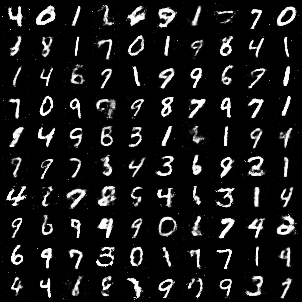

In [23]:
# show output after epochs training
Image(os.path.join(sample_dir, 'fake_images-0225.png'))

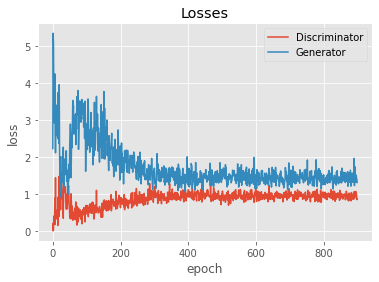

In [24]:
# show the discrimator loss and generator loss
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

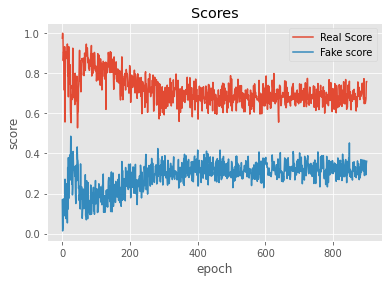

In [25]:
# plot the accuracy of discrimator
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');